# Identifying 10 regions similar to Moscow for wine consumption

## Executive summary
Market research shows the Russian wine market growing at 13% annually since 2015.  Furthermore, spending on wine has increased at 20.9% annually.  Thus, it is a great opportunity for wine retail to catch on the wave and expand sales, especially in undeveloped markets. 

Following the successful wine campaign in Moscow, the comapny would to find the top 10 regions with similar buying habits, to have successful wine promotions.  In this report, we found the 10 most similar regions are (in order of similarity): 
* Tver Oblast
* Sverdlovsk Oblast, Kaliningrad Oblast, Yaroslavl Oblast, Chukotka Autonomous Okrug, Pskov Oblast, Primorsky Krai, Republic of Karelia, Kaluga Oblast and Novgorod Oblast.

How was the analysis conducted?
1. Understanding the trend of alcohol consumption in Moscow vs the nation, broken down by type
2. Understanding the market share of wine consumption vs other types of alcohol in Moscow and the nation
3. Feature engineering to capture alcohol buying habits
- Regional median of recent alcohol consumption by type
- Correlation of alcohol trend in a region with Moscow's
- Regional share of wine consumption
4. Clustering to find similar regions to Moscow

## Contents


## The Dataset
The marketing team has sourced you with historical sales volumes per capita for several different drinks types.

* Key Variables *
"year" - year (1998-2016)
"region" - name of a federal subject of Russia. It could be oblast, republic, krai, autonomous okrug, federal city and a single autonomous oblast  
"wine" - sale of wine in litres by year per capita  
"beer" - sale of beer in litres by year per capita  
"vodka" - sale of vodka in litres by year per capita  
"champagne" - sale of champagne in litres by year per capita  
"brandy" - sale of brandy in litres by year per capita  

In [295]:
# importing modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# from scipy.cluster.hierarchy import linkage, dendrogram

random_seed = 31

In [299]:
raw_df = pd.read_csv(r'./data/russian_alcohol_consumption.csv')
df = raw_df.copy()
df['year'] = pd.to_datetime(df.year , format = '%Y')
df['region'] = df.region.astype('category')

df.sample(5, random_state=random_seed)



,year,region,wine,beer,vodka,champagne,brandy
1404,2014-01-01,Novgorod Oblast,12.0,53.7,10.5,2.0,1.0
656,2005-01-01,Sakhalin Oblast,6.9,39.5,19.1,2.2,1.0
157,1999-01-01,Tyumen Oblast,4.1,34.4,13.5,0.7,0.3
472,2003-01-01,Orenburg Oblast,2.5,28.7,8.5,0.6,0.2
131,1999-01-01,Omsk Oblast,7.5,36.0,16.6,1.1,0.5


In [334]:
segments = ['wine' , 'beer' , 'vodka' , 'champagne', 'brandy']
missing_df = df[df.isna().any(axis=1)]
print(missing_df.region.value_counts() , df.region.value_counts())

Chechen Republic          19
Sevastopol                16
Republic of Crimea        16
Republic of Ingushetia    15
Altai Krai                 0
                          ..
Kurgan Oblast              0
Krasnoyarsk Krai           0
Krasnodar Krai             0
Kostroma Oblast            0
Zabaykalsky Krai           0
Name: region, Length: 85, dtype: int64 Altai Krai                  19
Republic of Karelia         19
Sakha (Yakutia) Republic    19
Saint Petersburg            19
Ryazan Oblast               19
                            ..
Kurgan Oblast               19
Krasnoyarsk Krai            19
Krasnodar Krai              19
Kostroma Oblast             19
Zabaykalsky Krai            19
Name: region, Length: 85, dtype: int64


There are 4 regions in the dataset with many missing observations:  
* Chechen Republic
* Sevastopol
* Republic of Crimea
* Republic of Ingushetia  

We will remove data for these regions.

In [335]:
filter = df.region.isin( ['Republic of Ingushetia',
 'Republic of Crimea',
 'Sevastopol',
 'Chechen Republic'])
repaired_df = df[~filter].copy()
repaired_df['region'] = repaired_df.region.cat.remove_unused_categories()
# print(len(repaired_df), len(df))

3.Exploratory data analisys
First I will look for the data distribution and its development through time and comparing with Saint Petersburg data.

In [336]:
ref_region = 'Moscow'

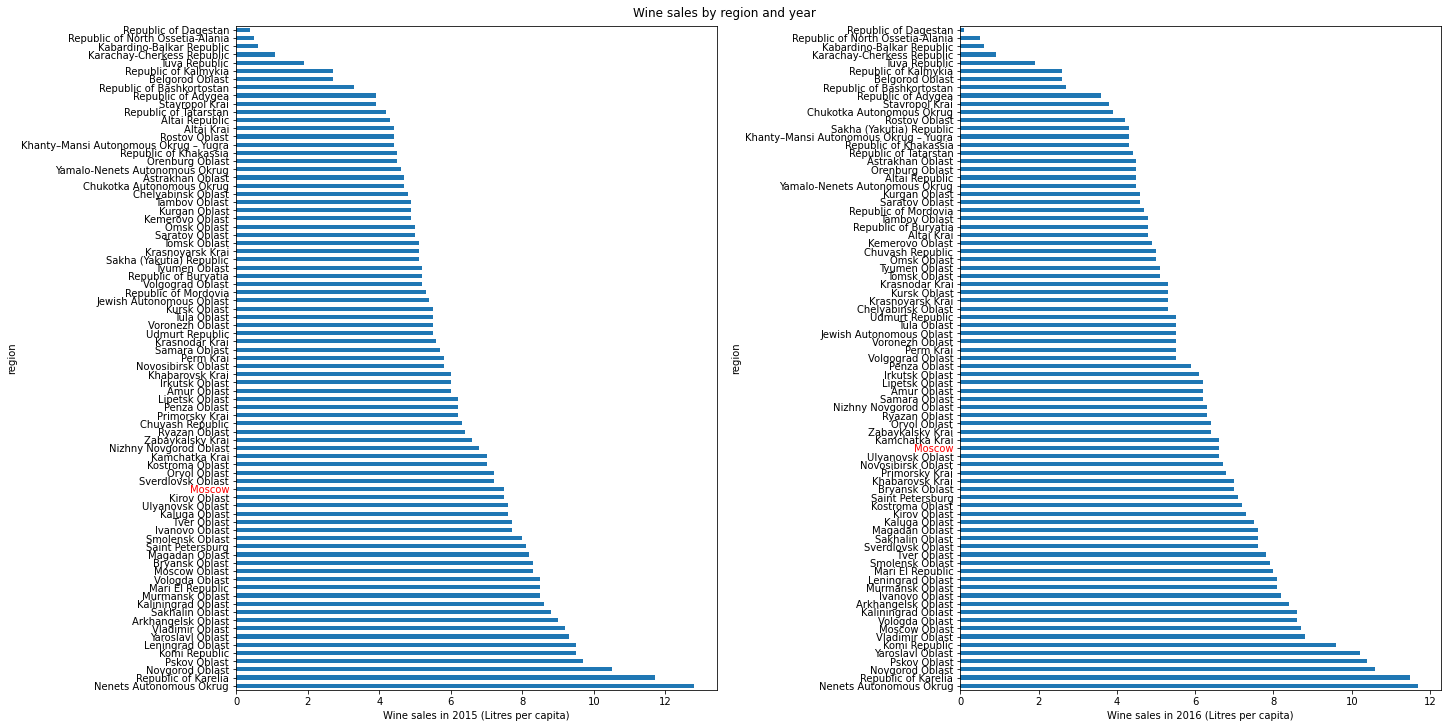

In [454]:
fig, axes = plt.subplots(1,2, figsize=(20,10), constrained_layout=True)
plt.suptitle('Wine sales by region and year')

def highlight_region(ax) :
    for text in ax.yaxis.get_ticklabels() :
        if text.get_text() == ref_region :
            text.set_color('red')

def plot_wine_sales(year, ax) :
    # ax = axes[0]
    plot_df = repaired_df[ repaired_df['year'] == year 
        ].set_index('region')['wine'].sort_values(ascending=False)
    ax.set_xlabel(f'Wine sales in {year} (Litres per capita)')
    plot_df.plot(kind='barh', ax = ax )
    highlight_region(ax)

plot_wine_sales('2015', axes[0])
plot_wine_sales('2016', axes[1])

We can see that there are regions with similar wine consumption to the target region in 2015 and 2016.  
However they are different - in 2015, the most similar regions were Orygl Oblast, Sverdiovsk Oblast, Kirov Oblast, Ulyanovsk Oblast and Kaluga Oblast.
in 2015, the most similar regions were ZabayKalsky Kraj, Kamchatka Kraj, Ulyanovsk Oblast, Novosibirsk Oblast and Primorsky Kraj.
This could be one of the aspects of buying habits.

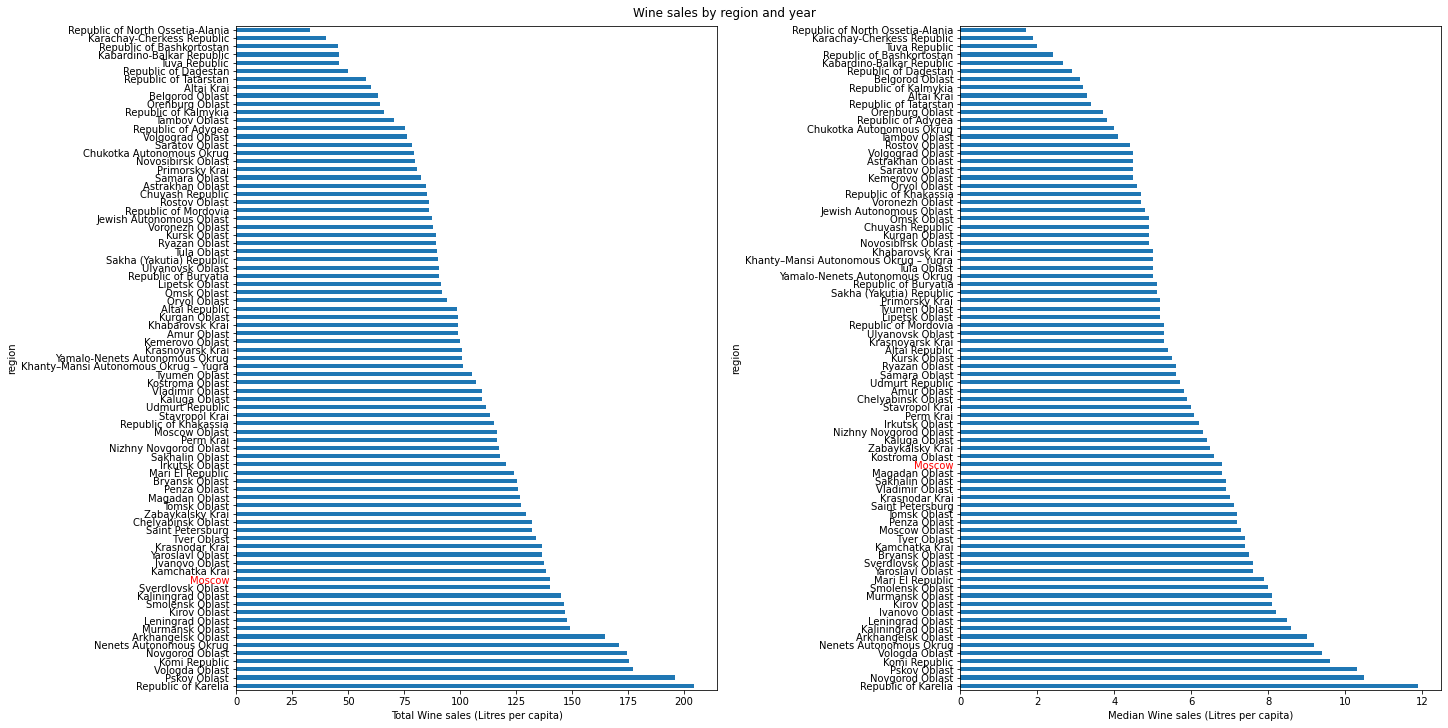

In [430]:
fig, axes = plt.subplots(1,2, figsize=(20,10), constrained_layout=True)
plt.suptitle('Wine sales by region and year')



ax = axes[0]
plot_df = repaired_df.groupby('region').sum()['wine'].sort_values(ascending=False)
ax.set_xlabel(f'Total Wine sales (Litres per capita)')
plot_df.plot(kind='barh', ax=ax)
highlight_region(ax)

ax = axes[1]
plot_df = repaired_df.groupby('region').median()['wine'].sort_values(ascending=False)
ax.set_xlabel(f'Median Wine sales (Litres per capita)')
plot_df.plot(kind='barh', ax=ax)
highlight_region(ax)


Intutively, there are also regions with similar total and median wine consumption to the target region. 
Again, the regions which are similar when dealing with a different aggregation. 
This could be one of the aspects of buying habits.  
Note also that Moscow has higher than average total and median wine sales.  


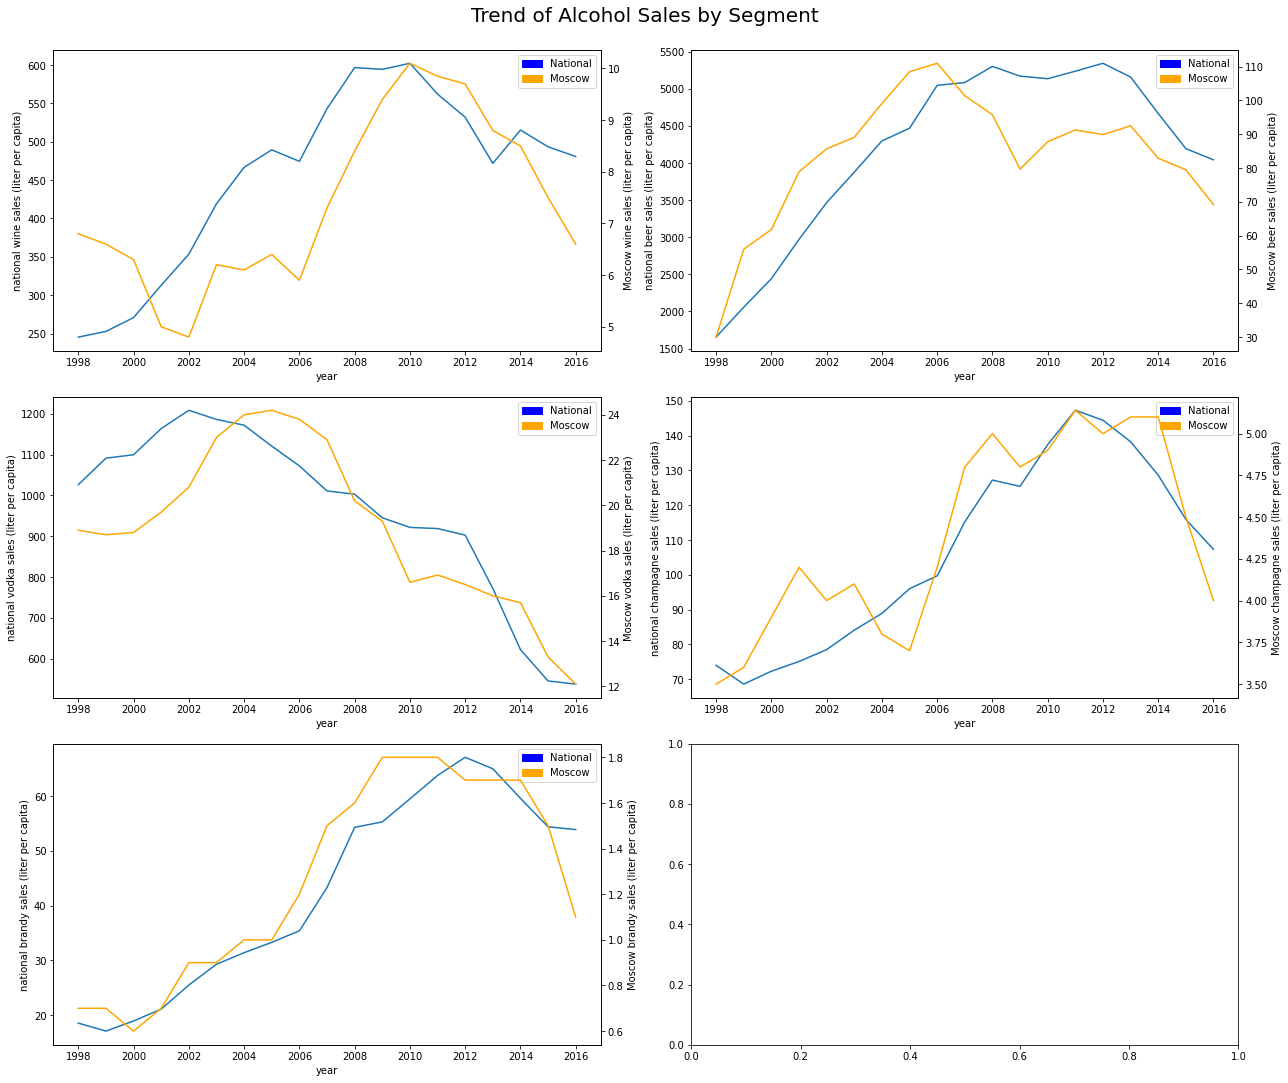

In [440]:
import matplotlib as mpl 

fig, axs = plt.subplots(3,2,figsize=(18,15),sharex=False)
fig.suptitle('Trend of Alcohol Sales by Segment', y=1 , fontsize = 20)
ref_df = repaired_df[ repaired_df['region'] == ref_region]
national_df = repaired_df.groupby('year').sum()
for i, segment in enumerate(segments):
    ax = axs[i//2, i%2]
    sns.lineplot(x='year', y= segment , data = national_df, ax = ax, label = 'National')
    ax.set_ylabel(f'National {segment} sales (liter per capita)')
    ax.legend(handles=[
        mpl.patches.Patch(color='blue', label='National'),
        mpl.patches.Patch(color='orange', label=ref_region),
    ])
    ax2 = ax.twinx()
    sns.lineplot(x='year', y= segment , data = ref_df, ax = ax2, color='orange' )
    ax2.set_ylabel(f'{ref_region} {segment} sales (liter per capita)')

plt.tight_layout()

* For wine sales trend, we see that Moscow is slightly different from the national total.  Moscow declines to a low in 2002, this is not seen nation-wide.  Moscow peaks later than the nation in 2010, before declining like the rest of the nation.  
* For beer sales trend, Moscow is also slightly different from the national total.  Moscow peaks earlier in 2006.  Moscow beer also declines to a lower level unlike the national total.  However, Moscow beer sales is the highest volume of alcohol, same as the nation.  
* For vodka sales trend, Moscow is more similar to the national total.  Moscow peaks later in 2005, before declining like the rest of the nation.  
* For champagne sales trend, Moscow's is more erratic than the nation.  It is most similar between 2007 and 2015 when it is on an increase.  
* For brandy sales trend, Moscow is more similar to the national total.  Moscow peaks earlier in 2009.  Moscow brandy also declines much more sharply in 2016 than the nation.  

The trends of alcohol consumption by type can also be one of the aspects of the buying habits.

All the distributions display a bell shape, which is a good characteristic. Anyway, for further analysis, it would be better if a logarithmic transformation is made. It wouldn't change the characteristics of our data but it will improve the performance of the predictive model.
Skewed right

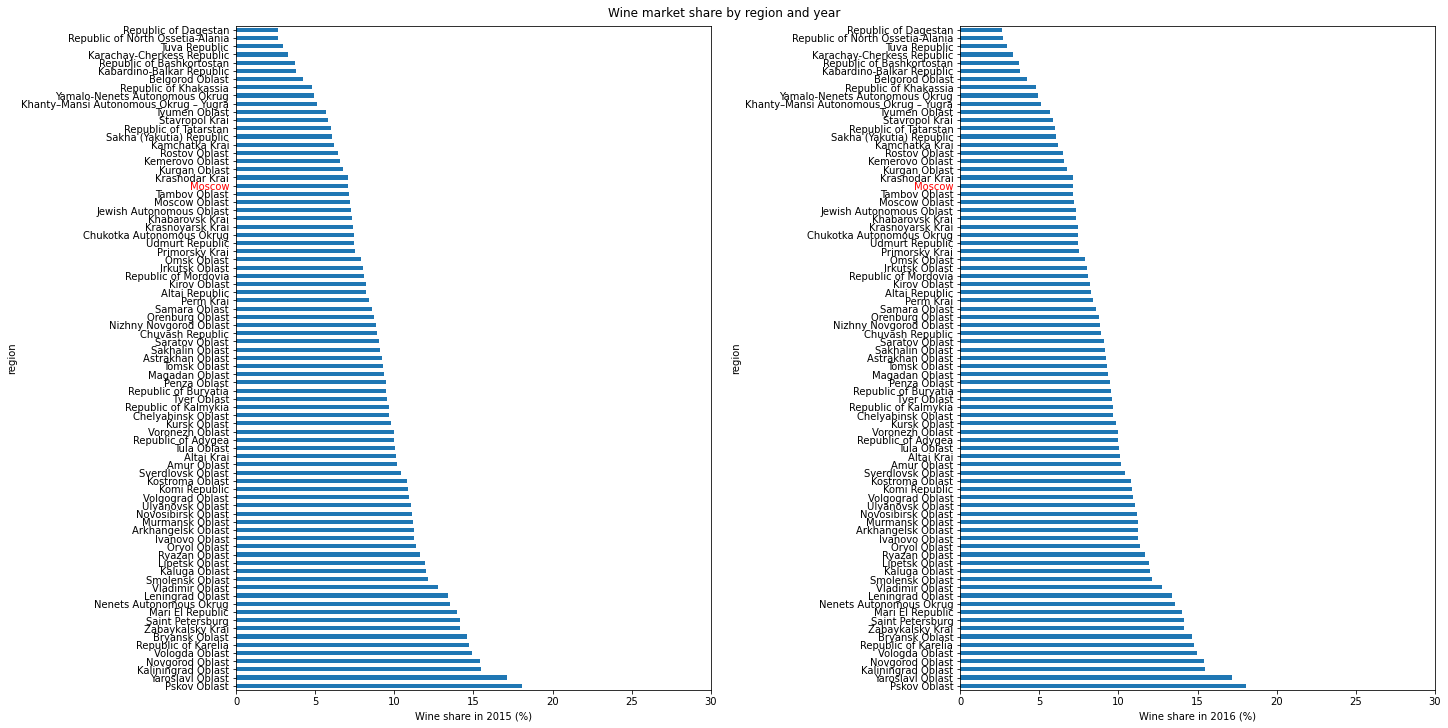

In [455]:
fig, axes = plt.subplots(1,2, figsize=(20,10), constrained_layout=True)
plt.suptitle('Wine market share by region and year')
def plot_wine_share(year, ax) :
    plot_df = repaired_df[ repaired_df['year'] == '2016' 
            ].set_index('region')
    plot_df['wine_share'] = plot_df.apply( 
        lambda row : 100 * row['wine'] / (row['wine'] + row['beer'] + row['vodka'] + row['champagne'] + row['brandy']), 
        axis=1,
    )
    ax.set_xlabel(f'Wine share in {year} (%)')
    ax.set_xlim(0, 30)
    series = plot_df['wine_share'].sort_values(ascending=False)
    series.plot(kind='barh', ax = ax )
    highlight_region(ax) 

plot_wine_share('2015', axes[0])
plot_wine_share('2016', axes[1])

We see that there are regions with the same share of wine sales as in Moscow in 2015, 2016.  
Regions with a similar market share may be a good fit for a similar promotion as in Moscow.  
This can be an aspect of the buying habits too.
However, Moscow has a lower than average market share.  
Selling to regions with high market share for wine may be more profitable! 


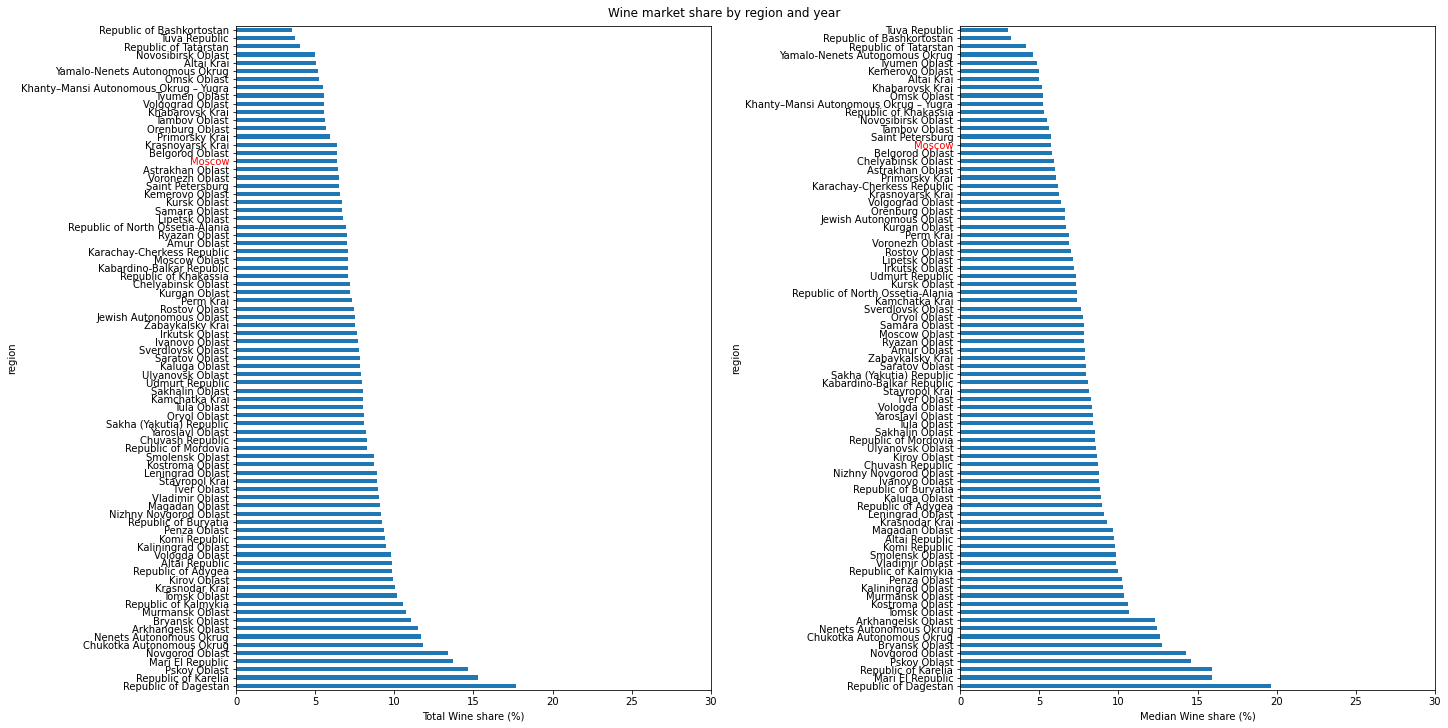

In [457]:
fig, axes = plt.subplots(1,2, figsize=(20,10), constrained_layout=True)
plt.suptitle('Wine market share by region and year')

ax = axes[0]
ax.set_xlabel(f'Total Wine share (%)')
ax.set_xlim(0, 30)
plot_df = repaired_df.groupby('region').sum()
plot_df['wine_share'] = plot_df.apply( 
    lambda row : 100 * row['wine'] / (row['wine'] + row['beer'] + row['vodka'] + row['champagne'] + row['brandy']), 
    axis=1,
)
series = plot_df['wine_share'].sort_values(ascending=False)
series.plot(kind='barh', ax = ax )
highlight_region(ax) 

ax = axes[1]
ax.set_xlabel(f'Median Wine share (%)')
ax.set_xlim(0, 30)
plot_df = repaired_df.groupby('region').median()
plot_df['wine_share'] = plot_df.apply( 
    lambda row : 100 * row['wine'] / (row['wine'] + row['beer'] + row['vodka'] + row['champagne'] + row['brandy']), 
    axis=1,
)
series = plot_df['wine_share'].sort_values(ascending=False)
series.plot(kind='barh', ax = ax )
highlight_region(ax) 

We see that there are regions with the same share of total / median wine sales as in Moscow.  
This can be an aspect of the buying habits too.

**Conclusion**

1. We found that the trend of alcohol sales in Moscow is slightly different from the national total.
2. However, there are regions that have a similar volume of wine sales in Moscow in certain years.
3. The regions are different for different years, and also for the median and total sales.
4. There are also regions that have a similar market share for wine to Moscow.
5. The exploration has shown that while similarity exists, picking out the most similar regions will not be straightforward.
6. Clustering seems to be a good mechanism to use to assess the similarity.



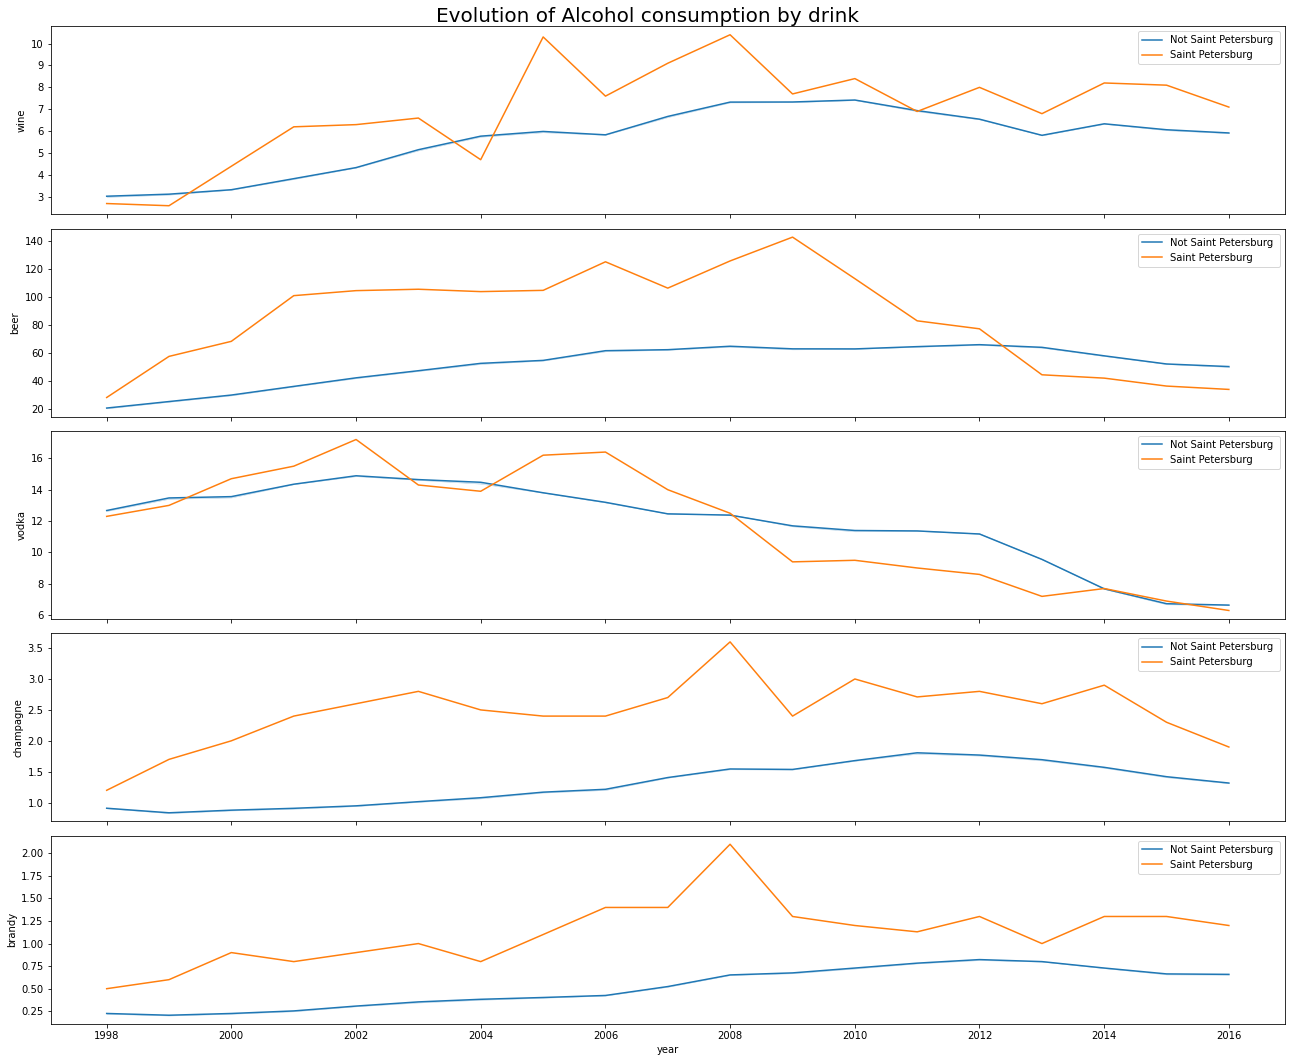

In [10]:
#Evolution Around the time Saint Petersburg and Not Saint Petersburg data
fig, axs = plt.subplots(5,1,figsize=(18,15),sharex=True)
fig.suptitle('Evolution of Alcohol consumption by drink' , fontsize = 20)
for i, col in enumerate(drinks):
    sns.lineplot(x='year', y= col , data = nsp_df, ax = axs[i] , label = 'Not Saint Petersburg ' , ci = False)
    sns.lineplot(x='year', y= col , data = sp_df, ax = axs[i], label = 'Saint Petersburg' , ci = False)
    # plt.legend()
plt.tight_layout()

Although, as we have seen before, the average alcohol consumption of Saint Petersburg is above the average alcohol consumption which does not include Saint Petersburg data, both data set show a similar trend.

For Brandy, the brandy consumption in StP grew from 1998 until 2006, where it pretty much stayed level except for an outlier in 2008.
Outside StP, brand consumption is growing steadily until 2012, after which it declined slightly.

Finally, I run a correlation of alcoholic drink consumptions, for the entire data set, non-Saint Petersburg data set, and Saint Petersburg data set.

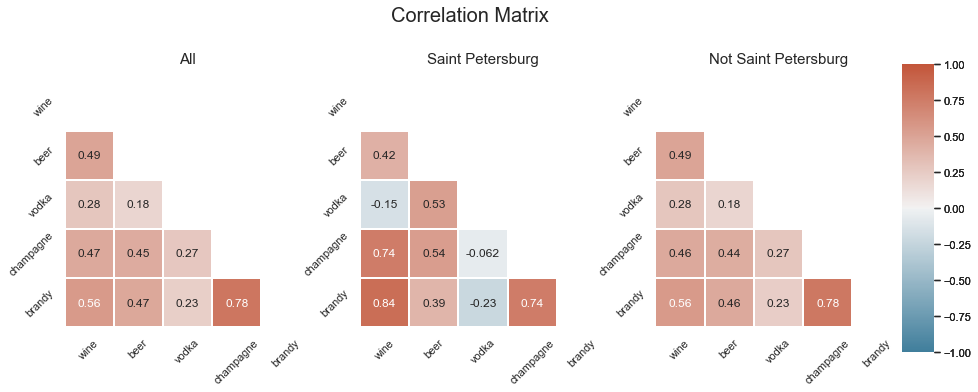

In [15]:
def mult_correlation_matrix(df1, df2, df3, data_set =['']*3):
    # Set up the matplotlib figure
    fig, axs = plt.subplots(1,3,figsize=(15, 20))                    # Set figure size
    l = [df1 , df2, df3]
    for i,df in enumerate(l):
        #Compute the correlation matrix
        corr = df.corr(method = 'pearson')

        # Generate a mask for the upper triangle
        mask = np.triu(np.ones_like(corr, dtype=bool))

    
        
        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(230, 20, as_cmap=True)
        cbar_ax = fig.add_axes([.9, .4, .03, .2])
        # Draw the heatmap with the mask 
        sns.heatmap(corr, 
                mask = mask, 
                cmap = cmap, 
                vmax = 1,                                      # Set scale min value
                vmin = -1,                                     # Set scale min value
                center = 0,                                    # Set scale min value
                square = True,                                 # Ensure perfect squares
                linewidths = 1.5,                              # Set linewidth between squares
                cbar_kws = {"shrink": .9},                     # Set size of color bar
                annot = True ,                                  # Include values within squares
                ax = axs[i],
                cbar_ax = cbar_ax 
                    
               );
        axs[i].tick_params(labelrotation=45)   # Rotate y labels
        axs[i].set_title(f'{data_set[i]}', size=10, y=1.05, fontsize =15);   # Set plot title and positionnsp_df.corr()
    fig.suptitle('Correlation Matrix', x=0.5 , y=0.64, fontsize = 20)

#Looking for correlation matrix
mult_correlation_matrix(df, sp_df, nsp_df , ['All', 'Saint Petersburg' , 'Not Saint Petersburg'])

## Feature Engineering

To do clustering, we will need to have one row of data for each region summarizing its buying habits, which is not the case now.

We can aggregate the data to find the median sales for each segment for the last ten years.
We can then derive the market share of wine in that region over the last ten years.
We can also calculate the correlation coefficeint between the sales trend in the region and the reference region 


In [185]:
df_5 = df.copy()
df_5 = df_5.loc[df_5.year >= '2010-01-01']
df_5_corr = df_5.groupby('region').corr()['wine'].T.unstack().drop(columns = 'wine')
df_5_corr

,beer,vodka,champagne,brandy
region,,,,
Altai Krai,-0.039845,0.073095,-0.132210,0.035548
Altai Republic,0.683169,0.663124,-0.031259,0.562694
Amur Oblast,0.567191,0.395589,0.115989,0.442995
Arkhangelsk Oblast,-0.385053,0.789181,0.768277,0.791038
Astrakhan Oblast,0.254728,0.412599,0.151128,-0.458320
...,...,...,...,...
Vologda Oblast,0.430761,0.603253,0.188507,0.100259
Voronezh Oblast,0.824537,0.787070,0.850945,0.042779
Yamalo-Nenets Autonomous Okrug,0.546515,0.811201,0.468799,0.267708


In [20]:
df_5_mean=df_5.groupby('region').mean()
df_5_mean

,wine,beer,vodka,champagne,brandy
region,,,,,
Altai Krai,4.444286,56.141429,7.821429,1.220000,0.357143
Altai Republic,4.887143,52.251429,8.884286,1.094286,0.402857
Amur Oblast,6.515714,67.367143,9.731429,1.700000,0.591429
Arkhangelsk Oblast,10.104286,49.328571,14.062857,2.198571,1.062857
Astrakhan Oblast,4.888571,64.501429,7.105714,0.981429,0.608571
...,...,...,...,...,...
Vologda Oblast,9.234286,73.004286,12.348571,1.184286,0.620000
Voronezh Oblast,6.274286,68.472857,6.801429,1.771429,0.534286
Yamalo-Nenets Autonomous Okrug,5.747143,90.088571,11.524286,2.161429,1.525714


In [17]:
#Creating trend variable
df_5_trend= df_5.sort_values(['region', 'year'])
df_5_trend['w_2010'] =df_5_trend['wine'].shift(6)   #I can use this way because all regions have the same numbers of observation
df_5_trend['trend'] = df_5_trend['wine']/df_5_trend['w_2010']   
df_5_trend = df_5_trend.loc[df_5_trend.year == '2016-01-01', ['region' , 'trend']]

In [18]:
#Merging Data sets
df_5_c_m = pd.merge(df_5_corr, df_5_mean , on='region' , suffixes = ('_corr' ,'_mean'))
df_5_c_m_t = pd.merge(df_5_c_m , df_5_trend, on ='region')
df_complete = df_5_c_m_t.set_index('region')

In [19]:
df_complete

,beer_corr,vodka_corr,champagne_corr,brandy_corr,wine,beer_mean,vodka_mean,champagne_mean,brandy_mean,trend
region,,,,,,,,,,
Altai Krai,-0.039845,0.073095,-0.132210,0.035548,4.444286,56.141429,7.821429,1.220000,0.357143,1.170732
Altai Republic,0.683169,0.663124,-0.031259,0.562694,4.887143,52.251429,8.884286,1.094286,0.402857,0.737705
Amur Oblast,0.567191,0.395589,0.115989,0.442995,6.515714,67.367143,9.731429,1.700000,0.591429,0.815789
Arkhangelsk Oblast,-0.385053,0.789181,0.768277,0.791038,10.104286,49.328571,14.062857,2.198571,1.062857,0.700000
Astrakhan Oblast,0.254728,0.412599,0.151128,-0.458320,4.888571,64.501429,7.105714,0.981429,0.608571,0.737705
...,...,...,...,...,...,...,...,...,...,...
Vologda Oblast,0.430761,0.603253,0.188507,0.100259,9.234286,73.004286,12.348571,1.184286,0.620000,0.934783
Voronezh Oblast,0.824537,0.787070,0.850945,0.042779,6.274286,68.472857,6.801429,1.771429,0.534286,0.833333
Yamalo-Nenets Autonomous Okrug,0.546515,0.811201,0.468799,0.267708,5.747143,90.088571,11.524286,2.161429,1.525714,0.584416


In [465]:

filtered_df = repaired_df[repaired_df['year'] > '2006']
filtered_df

,year,region,wine,beer,vodka,champagne,brandy
765,2007-01-01,Republic of Adygea,4.1,31.6,6.8,0.7,0.5
766,2007-01-01,Altai Krai,2.5,52.8,6.9,1.2,0.2
767,2007-01-01,Amur Oblast,5.7,64.6,17.3,1.0,0.3
768,2007-01-01,Arkhangelsk Oblast,10.1,40.3,15.6,1.6,0.8
769,2007-01-01,Astrakhan Oblast,4.1,64.0,9.6,0.9,0.3
...,...,...,...,...,...,...,...
1610,2016-01-01,Chuvash Republic,5.0,42.3,7.7,0.7,0.4
1611,2016-01-01,Chukotka Autonomous Okrug,3.9,34.0,11.6,1.8,1.1
1612,2016-01-01,Sakha (Yakutia) Republic,4.3,56.1,8.2,1.8,0.5
1613,2016-01-01,Yamalo-Nenets Autonomous Okrug,4.5,75.8,8.2,1.7,1.3


In [476]:
features_df = filtered_df.set_index('year').groupby('region').mean()
features_df['wine_sales_share'] = features_df.apply (lambda row : 
    row['wine'] / (row['wine'] + row['beer'] + row['vodka'] + row['champagne'] + row['brandy']), 
    axis = 1,
)
features_df.columns = ['mean_wine_sales', 'mean_beer_sales', 'mean_vodka_sales', 
    'mean_champagne_sales', 'mean_brandy_sales', 'wine_sales_share', ]


In [477]:
def get_corr(type, region1, region2) :
    return np.corrcoef(
        repaired_df[ repaired_df['region'] == region1 ][type],
        repaired_df[ repaired_df['region'] == region2 ][type], 
    )[0,1]

for region in features_df.index :
    for type in ['wine', 'beer', 'brandy', 'vodka', 'champagne',] :
        features_df.loc[region, type + '_sales_corr'] = get_corr(type, 'Saint Petersburg', region)

features_df.loc['Saint Petersburg']
features_df



,mean_wine_sales,mean_beer_sales,mean_vodka_sales,mean_champagne_sales,mean_brandy_sales,wine_sales_share,wine_sales_corr,beer_sales_corr,brandy_sales_corr,vodka_sales_corr,champagne_sales_corr
region,,,,,,,,,,,
Altai Krai,4.091,55.079,7.835,1.244,0.330,0.059654,0.276863,0.366096,0.531882,0.597115,0.394560
Altai Republic,5.051,51.256,9.359,0.996,0.392,0.075327,0.209446,0.210930,0.574049,0.590447,0.516061
Amur Oblast,6.471,68.257,10.972,1.530,0.544,0.073723,0.702777,0.285400,0.418090,0.935857,0.385761
Arkhangelsk Oblast,10.283,46.320,14.654,2.069,1.024,0.138305,0.737251,0.196827,0.403663,0.640373,0.655651
Astrakhan Oblast,4.922,65.701,7.714,0.957,0.536,0.061656,0.538794,0.468743,0.468021,0.828015,0.575155
...,...,...,...,...,...,...,...,...,...,...,...
Vologda Oblast,9.704,77.163,13.534,1.149,0.584,0.095012,0.434099,0.576139,0.459739,0.832865,0.347676
Voronezh Oblast,6.122,70.581,8.541,1.710,0.544,0.069967,0.598658,0.308412,0.775293,0.661791,0.432214
Yamalo-Nenets Autonomous Okrug,6.113,90.602,12.407,2.053,1.418,0.054293,0.502499,0.439537,0.491995,0.895975,0.510564


## Pre-Processing
Now, we prepare the data for clustering.
We need to normalize the data and minimize the impact of outliers.


We see that the distributions of mean_beer_sales, mean_brandy_sales, beer_sales_corr, champagne_sales_corr are skewed.
Distributions of mean_champagne_sales, wine_sales_corr, brandy_sales_corr, vodka_sales_corr  resemble an exponential distriution.  


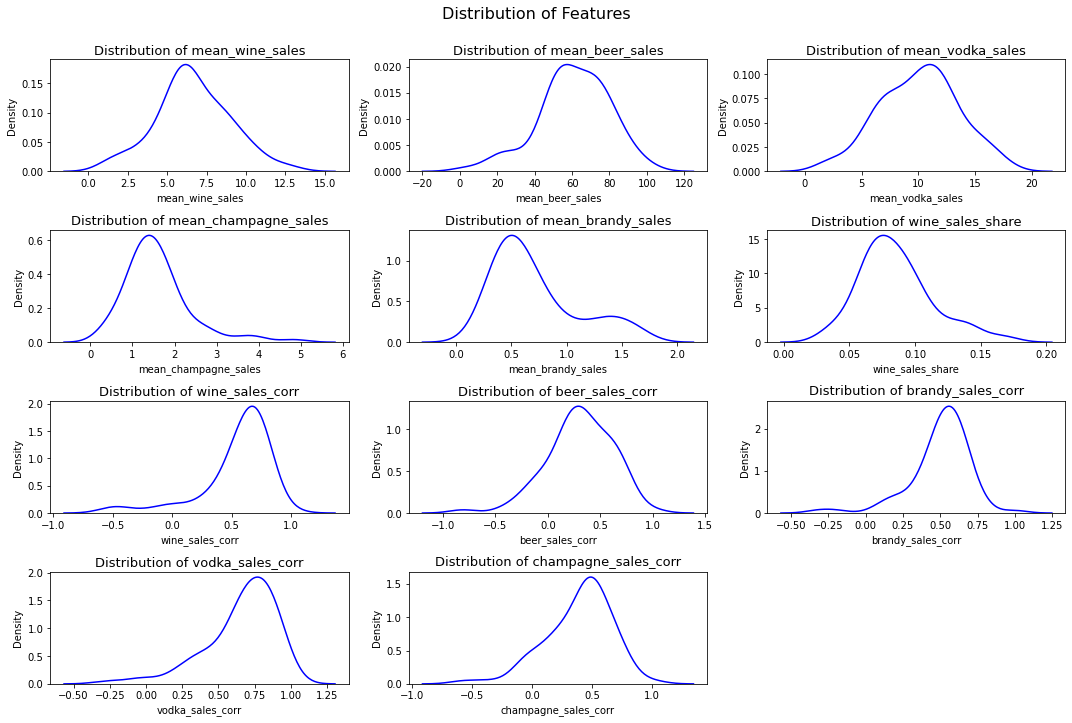

In [478]:
#Looking for distributions 
fig = plt.figure(figsize=(15, 10))
for i, col in enumerate(features_df.columns):
    # Plot lineplot 
    plt.subplot(4,3,i+1)
    sns.kdeplot( features_df[col], color='blue');
    plt.title(f'Distribution of {col}', fontsize=13)
fig.suptitle('Distribution of Features',y=1, fontsize=16)
plt.tight_layout()

In [21]:
#Def log transformation.
def to_log(df , log_cols):
    #apply a log transformation tu a numeric colum
    X = df.copy()
    for col in log_cols:
        X[col] =np.log(X[col] + 1) #Add 1 just to avoid Log(0) that it is not define.
    return X 

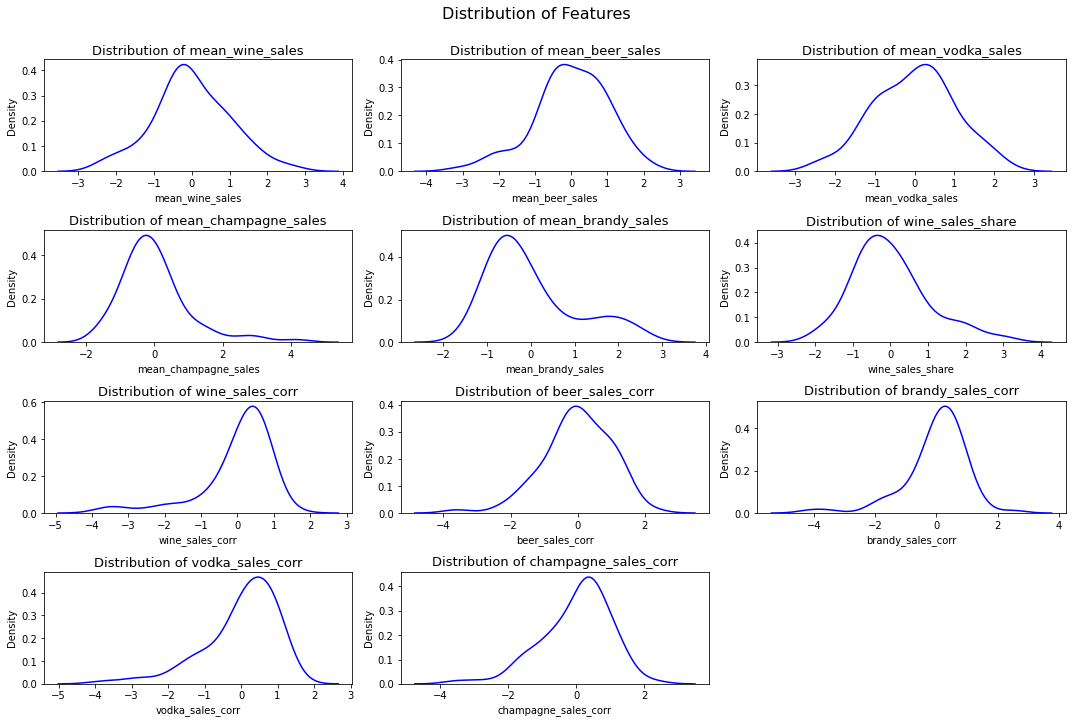

In [481]:
#Looking for distributions 
fig = plt.figure(figsize=(15, 10))
for i, col in enumerate(transformed_df.columns):
    # Plot lineplot 
    plt.subplot(4,3,i+1)
    sns.kdeplot( transformed_df[col], color='blue');
    plt.title(f'Distribution of {col}', fontsize=13)
fig.suptitle('Distribution of Features',y=1, fontsize=16)
plt.tight_layout()

In [480]:
scaler = StandardScaler()
transformed_arr =scaler.fit_transform(features_df)
transformed_df = pd.DataFrame(data = transformed_arr,
    index = features_df.index , columns = features_df.columns)
transformed_df

,mean_wine_sales,mean_beer_sales,mean_vodka_sales,mean_champagne_sales,mean_brandy_sales,wine_sales_share,wine_sales_corr,beer_sales_corr,brandy_sales_corr,vodka_sales_corr,champagne_sales_corr
region,,,,,,,,,,,
Altai Krai,-1.104327,-0.310783,-0.665447,-0.440566,-0.996707,-0.935799,-0.924328,0.192809,0.152916,-0.240639,0.024612
Altai Republic,-0.690976,-0.515003,-0.217214,-0.757535,-0.834650,-0.369398,-1.152241,-0.309768,0.365447,-0.267997,0.468408
Amur Oblast,-0.079561,0.393171,0.257195,-0.075029,-0.437348,-0.427359,0.515538,-0.068563,-0.420621,1.149236,-0.007525
Arkhangelsk Oblast,1.561788,-0.778679,1.340130,0.613867,0.817289,1.906468,0.632083,-0.355448,-0.493336,-0.063150,0.978275
Astrakhan Oblast,-0.746520,0.256632,-0.701035,-0.807381,-0.458259,-0.863445,-0.038830,0.525278,-0.168960,0.706752,0.684252
...,...,...,...,...,...,...,...,...,...,...,...
Vologda Oblast,1.312485,0.868919,1.010721,-0.561986,-0.332795,0.341972,-0.392767,0.873129,-0.210703,0.726655,-0.146634
Voronezh Oblast,-0.229831,0.517316,-0.457801,0.155029,-0.437348,-0.563096,0.163550,0.005972,1.379759,0.024731,0.162149
Yamalo-Nenets Autonomous Okrug,-0.233706,1.586815,0.679252,0.593417,1.847137,-1.129530,-0.161532,0.430681,-0.048122,0.985597,0.448329


5.Reducing dimensionality - PCA analysis
Now I apply a Principal Component Analysis(PCA), which is a technique to address dimensionality reduction and also remove multi-collinearity at the same time. In short, it transforms the data in a way that could express most of the variance, with the fewer variables possible in an attempt to avoid the curse of dimensionality

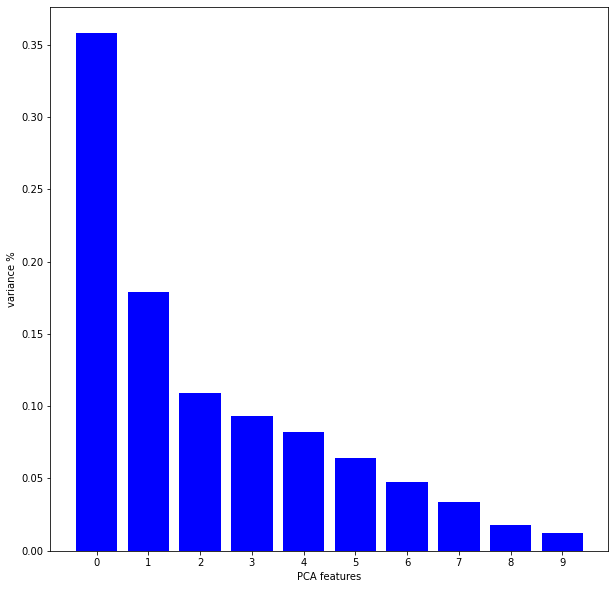

In [482]:
#Create a PCA instance:pca
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(transformed_df)
#Plot the explained variance
plt.figure(figsize = (10,10))
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_ , color = 'blue')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
#Saving components to a Data Frame 
PCA_components = pd.DataFrame(data = principalComponents , index = df_x_e.index)

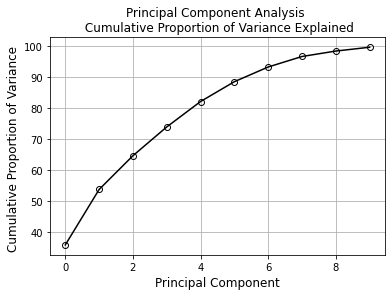

In [483]:
# Assign variance explained
var = pca.explained_variance_ratio_

# Plot cumulative variance
cumulative_var = np.cumsum(var)*100
plt.plot(cumulative_var,'k-o',markerfacecolor='None',markeredgecolor='k')
plt.title('Principal Component Analysis \n Cumulative Proportion of Variance Explained',fontsize=12)
plt.xlabel("Principal Component",fontsize=12)
plt.ylabel("Cumulative Proportion of Variance ",fontsize=12)
plt.grid()
plt.show()

From this plot, we see that 6 principal components accounts for >90% of the variance.  
We will be using these components will be used as features for clustering to analyze which regions are similar to StP.  
We note that we have only 81 observations (rows) in our transformed data.  
To avoid overfitting the model, we use only 4 principal components which can account for >80% of the the variance.


Text(0, 0.5, 'PCA 2')

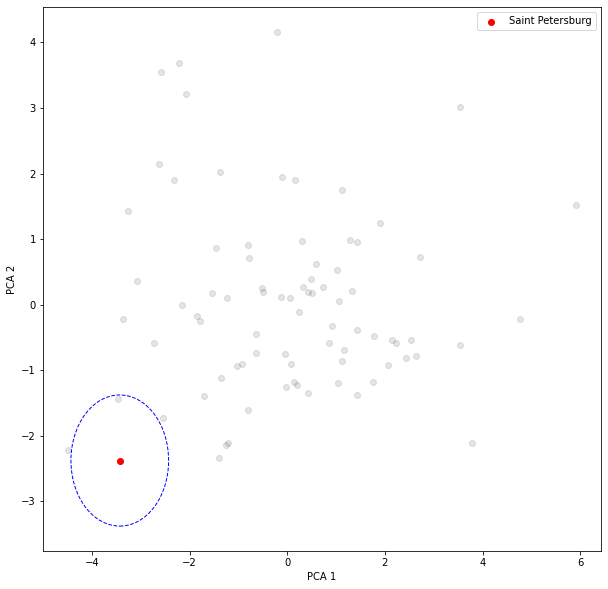

In [484]:
chosen_PCA_components = PCA_components.iloc[:, :3].copy()

plt.figure(figsize = (10,10))
ax = plt.gca()
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.scatter(PCA_components.loc['Saint Petersburg'][0], 
            PCA_components.loc['Saint Petersburg'][1], 
            color = 'red', label = 'Saint Petersburg')
circle = plt.Circle((PCA_components.loc['Saint Petersburg'][0], 
                      PCA_components.loc['Saint Petersburg'][1]), 
                     1, color='b', 
                     ls = '--',
                     fill=False)
ax.add_patch(circle)
plt.legend()
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

It seems that there are very good candidates that are similar to Saint Petersburg. Anyway, here we use just the 2 most important features, instead of 4, so when we add the remaining features we will get a more accurate result.

## Clustering
Clustering refers to a very set of techniques for finding subgroups in a data set?.  
The goal is that the observation within every group were similar to each other.  
In K-means clustering we look to find K non-overlapping clusters, wherein every group the variation between the cluster members should be small as possible.

One of the problems of this clustering method is to address the question about how many clusters exist?  
Too many clusters should cause overfitting but too little should cause biased conclusions.  
To answer this question one should do an elbow analysis, in which you should choose the number of clusters that gives a high reduction of the inertia ( inertia is a measure of how coherent is every cluster internally).

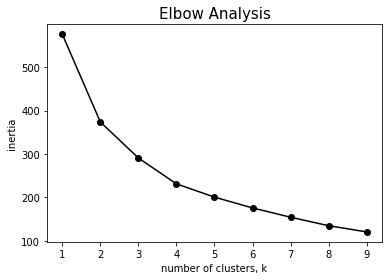

In [485]:

import warnings

ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    with warnings.catch_warnings():
        warnings.simplefilter('ignore') # ignore UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads.
        model = KMeans(n_clusters=k)
        model.fit(chosen_PCA_components)
        inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.title('Elbow Analysis', fontsize = 15)
plt.show()

Looking at the elbow analysis, we should conclude that using 4 or 5 clusters would be okay, additional clusters don't reduce the inertia too much.

In [486]:
#Run Kmeans model with 4 cluster
km = KMeans(n_clusters=4) 
km.fit(chosen_PCA_components)
centers = km.cluster_centers_
label = km.predict(chosen_PCA_components)
chosen_PCA_components['label'] = label
sp_label = chosen_PCA_components.loc[ref_region,'label']

In [290]:
# cluster_df = chosen_PCA_components['label'].reset_index()
# cluster_df.columns = ['region', 'cluster']
# cluster_crosstab = pd.crosstab( cluster_df['cluster'], cluster_df['region'],  )

cluster_df = pd.DataFrame({
    'label': label, 
    'region': chosen_PCA_components.index, 
}).sort_values('label')
index = cluster_df[ cluster_df['region'] == 'Saint Petersburg'].index[0]
cluster_df.loc[index:].head(10)


,label,region
58,0,Saint Petersburg
33,0,Moscow Oblast
70,0,Tver Oblast
71,0,Tyumen Oblast
35,0,Nenets Autonomous Okrug
7,0,Chelyabinsk Oblast
76,0,Vologda Oblast
3,0,Arkhangelsk Oblast
78,0,Yamalo-Nenets Autonomous Okrug
34,0,Murmansk Oblast


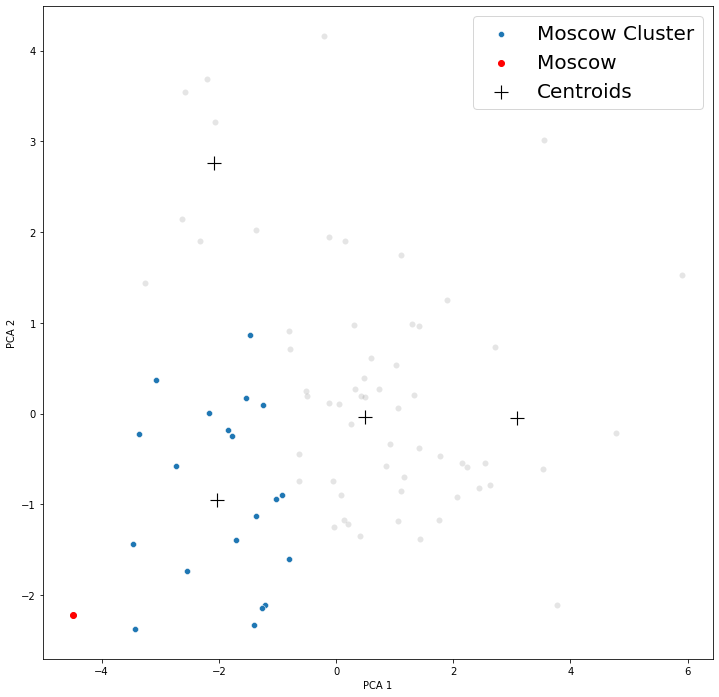

In [487]:
plt.figure(figsize=(12,12))
sns.scatterplot(x=0, y= 1 , 
                data = chosen_PCA_components,
                alpha = 0.1,
                color = 'black')
sns.scatterplot(x=chosen_PCA_components.loc[chosen_PCA_components.label==sp_label][0],
                y=chosen_PCA_components.loc[chosen_PCA_components.label==sp_label][1], 
               label = ref_region + ' Cluster')
plt.scatter(x=chosen_PCA_components.loc[ref_region][0],
                y=chosen_PCA_components.loc[ref_region][1],
                color = 'red',
           label = ref_region)
sns.scatterplot(x=centers[:,0], y=centers[:,1], 
                marker='+', 
                color='black',
                label ='Centroids',
                s=200);
plt.legend(fontsize=20)
plt.xlabel('PCA 1')
_ = plt.ylabel('PCA 2')

Now that we have the cluster Saint Petersburg with other similar regions, but unfortunately the cluster has more than ten regions. To tackle the objective of this exercise and only pick ten regions, I just select the ten nearest regions to the centroid which belongs to Saint Petersburg.

#Selecting t


In [ ]:
#Selecting ten nearest region to centroid 
PCA_components['distance'] = km.transform(PCA_components.iloc[:,:3]).mean(axis=1)
Conclusion= PCA_components[PCA_components.label == sp_label].sort_values('distance').drop(['Saint Petersburg']).index[:10]
pd.DataFrame(Conclusion)

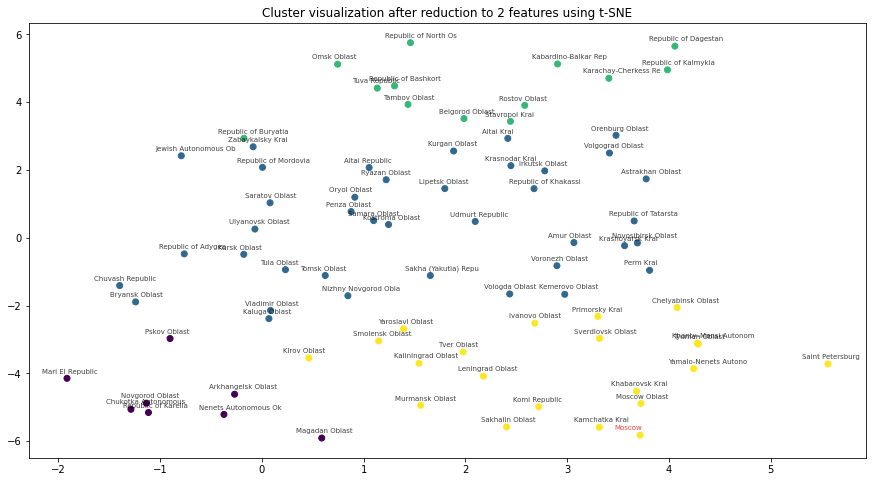

In [496]:
from sklearn.manifold import TSNE 
model = TSNE(init='random', learning_rate='auto', random_state=random_seed )
tsne_features = model.fit_transform(
    chosen_PCA_components.drop('label', axis=1)
)
xs = tsne_features[:,0]
ys = tsne_features[:,1]
plt.figure( figsize=(15,8))
plt.scatter(
    xs, ys,
    c = chosen_PCA_components['label']
)
plt.title('Cluster visualization after reduction to 2 features using t-SNE')

regions = chosen_PCA_components.index
for x,y,region in zip(xs, ys,regions) :
    if region == ref_region :
        color = 'red'
    else :
        color = 'black'
    plt.annotate(region[:20], (x-0.25, y+0.15), alpha=0.75, fontsize=7, color=color, )

# plt.xlim(2,6)
# plt.ylim(-6, 0)


T-distributed stochastic neighbor embedding (t-SNE) is a tool that maps high-dimensional data to 2 or 3 dimensions to be visualized.  
Note that the axis of the plot do not have any interpretable meaning.

In [494]:
tsne_df = pd.DataFrame(tsne_features, index=chosen_PCA_components.index)
tsne_df.columns = ['x', 'y']
origin_region_x, origin_region_y = tsne_df.loc[ref_region]

tsne_df['distance'] = tsne_df.apply( 
    lambda row : (row['x'] - origin_region_x) ** 2 + (row['y'] - origin_region_y) ** 2, 
    axis=1, )
tsne_df.sort_values('distance')[1:11].index.to_list()


['Kamchatka Krai',
 'Moscow Oblast',
 'Khabarovsk Krai',
 'Komi Republic',
 'Sakhalin Oblast',
 'Yamalo-Nenets Autonomous Okrug',
 'Leningrad Oblast',
 'Murmansk Oblast',
 'Tyumen Oblast',
 'Khanty–Mansi Autonomous Okrug – Yugra']

* Chukotka Autonomous Okrug, 
Tver Oblast, Sverdlovsk Oblast, Kaliningrad Oblast, Yaroslavl Oblast, Pskov Oblast, Primorsky Krai, Republic of Karelia, Kaluga Oblast and Novgorod Oblast.